In [27]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

Sick & Healthy ids

In [2]:
with open("data/eid_sick") as f:
    eid_sick = list(map(int, f.read().split('\n')))

with open("data/eid_healthy") as f:
    eid_healthy = list(map(int, f.read().split('\n')))

len(eid_sick), len(eid_healthy)

(26314, 476056)

Columns

In [3]:
column_desc = {}

with open("data/filtered_fields") as f:
    lines = f.read().split('\n')
    
    for line in lines:
        if line == '':
            continue
        
        # New category
        if line[0] == '#':
            category = line.split(' - ')[-1]
            column_desc[category] = {}
            
        # Fill category
        else:
            field, fdesc, ftype = line.split('\t')
            column_desc[category][f'{field}-0.0'] = fdesc

print(f'{len(column_desc)} categories, total of {sum([len(fields) for fields in column_desc.values()])} columns')
print('===================================')
for category, cols in column_desc.items():
    print(f'{category}: {len(cols)} columns')

11 categories, total of 193 columns
Physical activity: 24 columns
Sleep: 7 columns
Smoking: 26 columns
Diet: 28 columns
Alcohol: 19 columns
Chest pain: 4 columns
Blood pressure: 8 columns
Arterial stiffness: 8 columns
Body size measures: 8 columns
Blood count: 31 columns
Blood biochemistry: 30 columns


In [4]:
treatment_cols = {
    "864-0.0": "walks (#d/w)",
    "874-0.0": "walk duration (#m/d)",
    "884-0.0": "moderate (#d/w)",
    "894-0.0": "moderate duration (#m/d)",
    "904-0.0": "vigorous (#d/w)",
    "914-0.0": "vigorous duration (#m/d)"
}

matching_cols = column_desc['Blood biochemistry']

Data

In [5]:
selected_cols = list(matching_cols.keys()) + list(treatment_cols.keys())

df = pd.read_csv('data/my_data.csv', usecols=['eid', *selected_cols], index_col='eid')

# Missing Values

([], [])

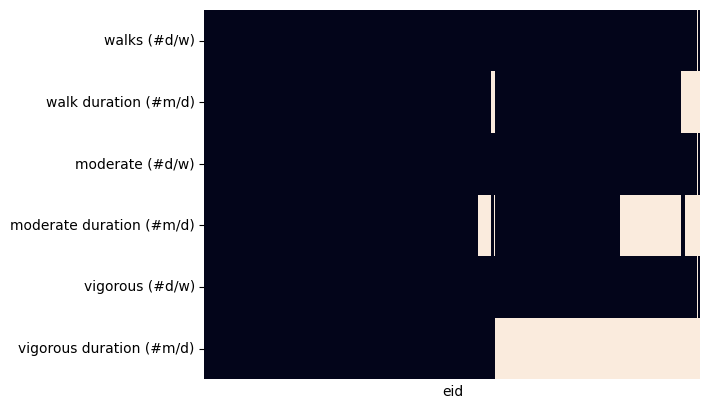

In [6]:
sns.heatmap(df[treatment_cols.keys()].isna().sort_values(['914-0.0', '874-0.0', '894-0.0']).T, yticklabels=treatment_cols.values(), cbar=False)
plt.xticks([])

In [7]:
info = pd.DataFrame(index=[*(matching_cols | treatment_cols)])
info = info.assign(description=[*matching_cols.values(), *treatment_cols.values()],
                   missing=[df[col].isna().sum() for col in matching_cols | treatment_cols],
                   negative=[(df[col] < 0).sum() for col in matching_cols | treatment_cols])
info = info.assign(invalid=info.missing+info.negative)
info

,description,missing,negative,invalid
30620-0.0,Alanine aminotransferase,33092,0,33092
30600-0.0,Albumin,72406,0,72406
30610-0.0,Alkaline phosphatase,32891,0,32891
30630-0.0,Apolipoprotein A,74970,0,74970
30640-0.0,Apolipoprotein B,35285,0,35285
30650-0.0,Aspartate aminotransferase,34696,0,34696
30710-0.0,C-reactive protein,33925,0,33925
30680-0.0,Calcium,72549,0,72549
30690-0.0,Cholesterol,32904,0,32904
30700-0.0,Creatinine,33136,0,33136


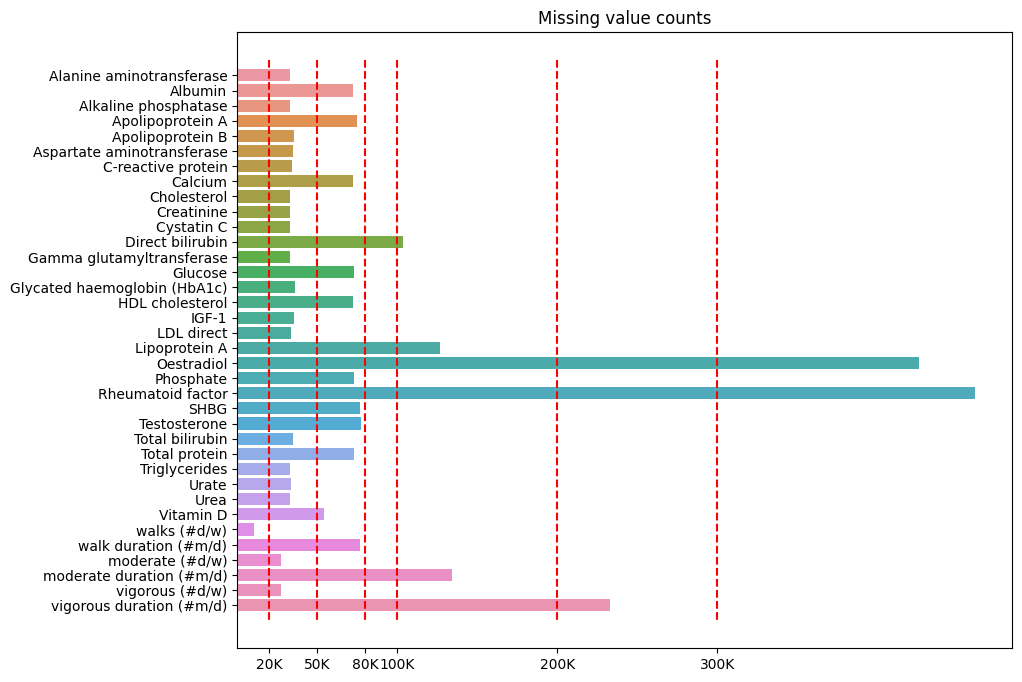

In [8]:
ths = np.array([20000, 50000, 80000, 100000, 200000, 300000])

plt.figure(figsize=(10, 8))
sns.barplot(data=info, y='description', x='invalid')
plt.xticks(ticks=ths, labels=[f'{th//1000}K' for th in ths])
plt.xlabel("")
plt.ylabel("")
plt.title("Missing value counts")

for th in ths:
    plt.plot(np.ones(len(info) + 2) * th, np.arange(-1, len(info) + 1), 'r--')

In [9]:
filtered_matching_cols = info.loc[matching_cols.keys()][info['invalid'] < 100000].index.tolist()
filtered_treatment_cols = info.loc[treatment_cols.keys()][info['invalid'] < 300000].index.tolist()

filtered_cols = filtered_matching_cols + filtered_treatment_cols

df_filtered = df[filtered_cols].copy()
df_filtered[df[filtered_cols] < 0] = np.nan
df_filtered.dropna(inplace=True)

/tmp/ipykernel_173101/3063600178.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_matching_cols = info.loc[matching_cols.keys()][info['invalid'] < 100000].index.tolist()
/tmp/ipykernel_173101/3063600178.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_treatment_cols = info.loc[treatment_cols.keys()][info['invalid'] < 300000].index.tolist()


In [10]:
print(f'{len(df_filtered)} rows')
df_filtered.columns

163258 rows


Index(['30620-0.0', '30600-0.0', '30610-0.0', '30630-0.0', '30640-0.0',
       '30650-0.0', '30710-0.0', '30680-0.0', '30690-0.0', '30700-0.0',
       '30720-0.0', '30730-0.0', '30740-0.0', '30750-0.0', '30760-0.0',
       '30770-0.0', '30780-0.0', '30810-0.0', '30830-0.0', '30850-0.0',
       '30840-0.0', '30860-0.0', '30870-0.0', '30880-0.0', '30670-0.0',
       '30890-0.0', '864-0.0', '874-0.0', '884-0.0', '894-0.0', '904-0.0',
       '914-0.0'],
      dtype='object')

# Matching

Define treatment measure

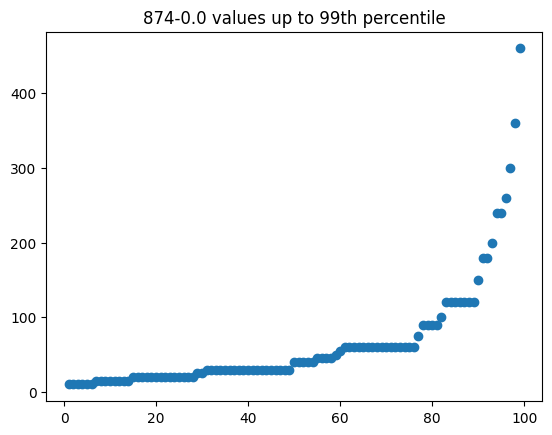

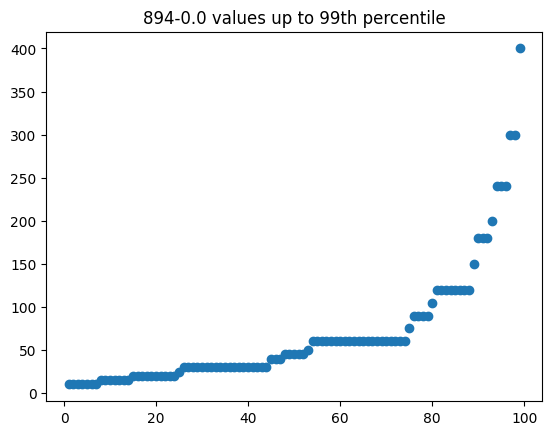

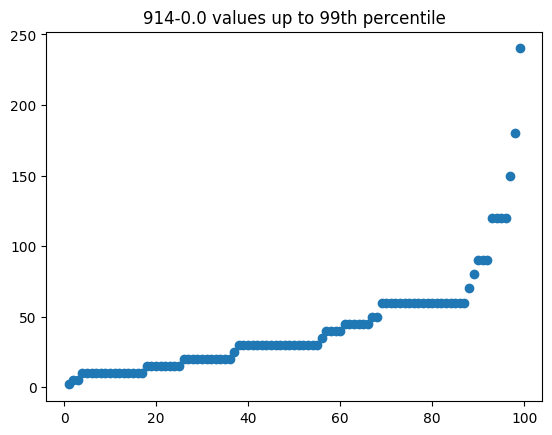

In [11]:
for col in ['874-0.0', '894-0.0', '914-0.0']:
    plt.scatter(x=np.arange(start=1, stop=100), y=[np.percentile(df_filtered[col], p) for p in range(1, 100)])
    plt.title(f'{col} values up to 99th percentile')
    plt.show()

In [12]:
for col in ['874-0.0', '894-0.0', '914-0.0']:
    df_filtered.drop(df_filtered.index.to_numpy()[df_filtered[col] > np.percentile(df_filtered[col], 95)], inplace=True)

In [13]:
df_filtered.columns

Index(['30620-0.0', '30600-0.0', '30610-0.0', '30630-0.0', '30640-0.0',
       '30650-0.0', '30710-0.0', '30680-0.0', '30690-0.0', '30700-0.0',
       '30720-0.0', '30730-0.0', '30740-0.0', '30750-0.0', '30760-0.0',
       '30770-0.0', '30780-0.0', '30810-0.0', '30830-0.0', '30850-0.0',
       '30840-0.0', '30860-0.0', '30870-0.0', '30880-0.0', '30670-0.0',
       '30890-0.0', '864-0.0', '874-0.0', '884-0.0', '894-0.0', '904-0.0',
       '914-0.0'],
      dtype='object')

<Axes: xlabel='hours_per_week', ylabel='Count'>

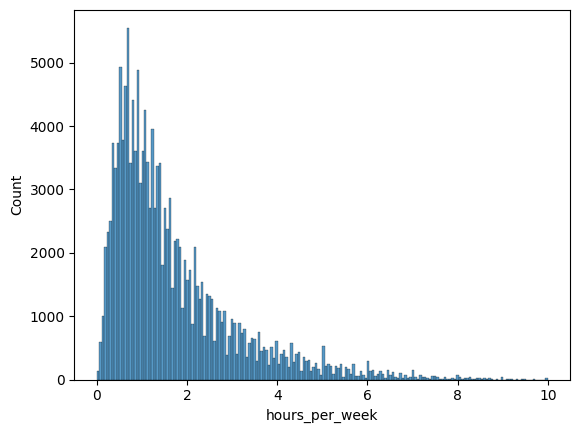

In [14]:
df_filtered['hours_per_week'] = (
    df_filtered['864-0.0'] * df_filtered['874-0.0'] + 
    df_filtered['884-0.0'] * df_filtered['894-0.0'] + 
    df_filtered['904-0.0'] * df_filtered['914-0.0']
) / 7 / 60


sns.histplot(data=df_filtered, x='hours_per_week')

In [15]:
treatment_high = 3.5
treatment_low = 0.5

df_filtered['treatment_yes'] = np.where(df_filtered['hours_per_week'] >= treatment_high, 1, 0)
df_filtered['treatment_no'] = np.where(df_filtered['hours_per_week'] <= treatment_low, 1, 0)
df_filtered['treatment'] = df_filtered['treatment_yes'] - df_filtered['treatment_no']

f"treatment = {(df_filtered['treatment'] == 1).sum()}, no treatment = {(df_filtered['treatment'] == -1).sum()}"

'treatment = 15734, no treatment = 20840'

In [17]:
df_treatment = df_filtered[df_filtered['treatment'] == 1][filtered_matching_cols]
df_control = df_filtered[df_filtered['treatment'] == -1][filtered_matching_cols]

Log Odds-ratio `BEFORE` matching

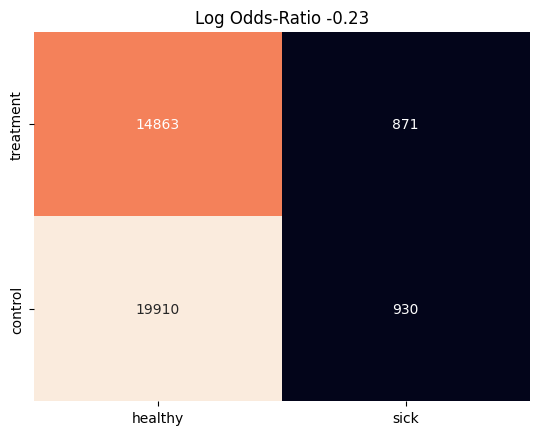

In [18]:
num_sick_treatment = len(set(df_treatment.index.tolist()) & set(eid_sick))
num_sick_control = len(set(df_control.index.tolist()) & set(eid_sick))
num_healthy_treatment = len(set(df_treatment.index.tolist()) & set(eid_healthy))
num_healthy_control = len(set(df_control.index.tolist()) & set(eid_healthy))

treatment_odds = num_healthy_treatment / num_sick_treatment
control_odds = num_healthy_control / num_sick_control
odds_ratio = treatment_odds / control_odds
log_odds_ratio = np.log(odds_ratio)

sns.heatmap(data=pd.DataFrame({
    'healthy': [num_healthy_treatment, num_healthy_control],
    'sick': [num_sick_treatment, num_sick_control]   
}), xticklabels=['healthy', 'sick'], yticklabels=['treatment', 'control'], annot=True, fmt='d', cbar=False)
plt.title(f'Log Odds-Ratio {log_odds_ratio:.2f}')
plt.show()

Apply matching

In [19]:
std_devs = df_filtered[df_filtered['treatment'] != 0][filtered_matching_cols].std()

df_treatment_std = df_treatment / std_devs
df_control_std = df_control / std_devs

In [20]:
eid_control_selected = []

for t in df_treatment.index:
    distances = np.sqrt(((df_control_std - df_treatment_std.loc[t]) ** 2).sum(axis=1))
    eid_selected = distances.index[distances.argmin()]
    
    eid_control_selected.append(eid_selected)
    df_control_std.drop(eid_selected, inplace=True)

In [21]:
df_control_matched = df_filtered[df_filtered['treatment'] == -1][filtered_matching_cols].loc[eid_control_selected]

In [22]:
min_distances = [
    np.sqrt(((df_control_matched.loc[x] / std_devs - df_treatment_std.loc[y]) ** 2).sum()) 
    for x, y in zip(eid_control_selected, df_treatment.index)
]

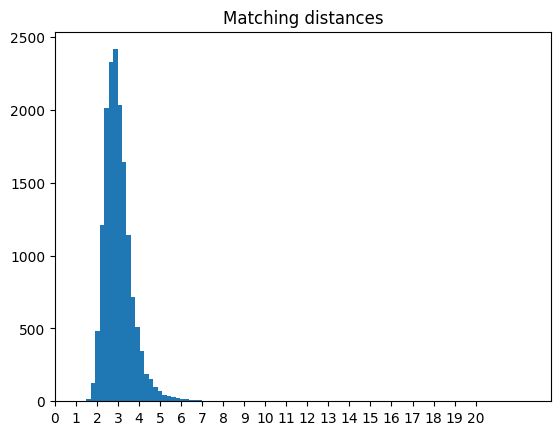

In [23]:
plt.hist(min_distances, bins=100)
plt.xticks(np.arange(21))
plt.title('Matching distances')
plt.show()

Log Odds-ratio `AFTER` matching

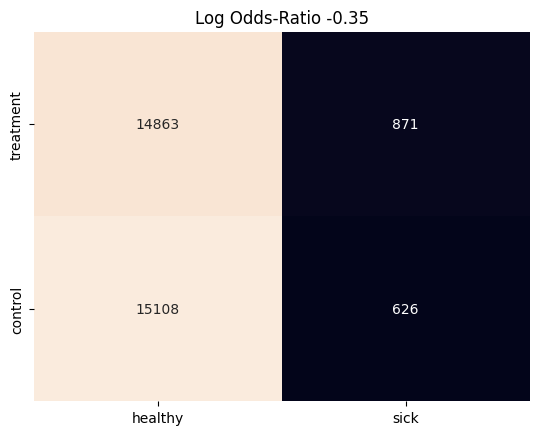

In [24]:
num_sick_treatment = len(set(df_treatment.index.tolist()) & set(eid_sick))
num_sick_control = len(set(df_control_matched.index.tolist()) & set(eid_sick))
num_healthy_treatment = len(set(df_treatment.index.tolist()) & set(eid_healthy))
num_healthy_control = len(set(df_control_matched.index.tolist()) & set(eid_healthy))

treatment_odds = num_healthy_treatment / num_sick_treatment
control_odds = num_healthy_control / num_sick_control
odds_ratio = treatment_odds / control_odds
log_odds_ratio = np.log(odds_ratio)

sns.heatmap(data=pd.DataFrame({
    'healthy': [num_healthy_treatment, num_healthy_control],
    'sick': [num_sick_treatment, num_sick_control]   
}), xticklabels=['healthy', 'sick'], yticklabels=['treatment', 'control'], annot=True, fmt='d', cbar=False)
plt.title(f'Log Odds-Ratio {log_odds_ratio:.2f}')
plt.show()

Apply `caliper`

In [32]:
def apply_caliper(c, print_counts=False):
    caliper = c
    eid_control_to_remove = []
    eid_treatment_to_remove = []

    for i, (x, y) in enumerate(zip(df_control_matched.index, df_treatment.index)):
        if min_distances[i] > caliper:
            eid_control_to_remove.append(x)
            eid_treatment_to_remove.append(y)
        
    df_control_caliper = df_control_matched.drop(eid_control_to_remove)
    df_treatment_caliper = df_treatment.drop(eid_treatment_to_remove)
    
    num_sick_treatment = len(set(df_treatment_caliper.index.tolist()) & set(eid_sick))
    num_sick_control = len(set(df_control_caliper.index.tolist()) & set(eid_sick))
    num_healthy_treatment = len(set(df_treatment_caliper.index.tolist()) & set(eid_healthy))
    num_healthy_control = len(set(df_control_caliper.index.tolist()) & set(eid_healthy))



    treatment_odds = num_healthy_treatment / num_sick_treatment
    control_odds = num_healthy_control / num_sick_control
    odds_ratio = treatment_odds / control_odds
    log_odds_ratio = np.log(odds_ratio)

    if print_counts:
        sns.heatmap(data=pd.DataFrame({
            'healthy': [num_healthy_treatment, num_healthy_control],
            'sick': [num_sick_treatment, num_sick_control]   
        }), xticklabels=['healthy', 'sick'], yticklabels=['treatment', 'control'], annot=True, fmt='d', cbar=False)
        plt.title(f'Log Odds-Ratio {log_odds_ratio:.2f}')
        plt.show()
    
    return log_odds_ratio
    

([<matplotlib.axis.XTick at 0x7f5fe1ff75e0>,
 [Text(0, 0, '2.0'),
  Text(5, 0, '2.5'),
  Text(10, 0, '3.0'),
  Text(15, 0, '3.5'),
  Text(20, 0, '4.0'),
  Text(25, 0, '4.5'),
  Text(30, 0, '5.0'),
  Text(35, 0, '5.5'),
  Text(40, 0, '6.0')])

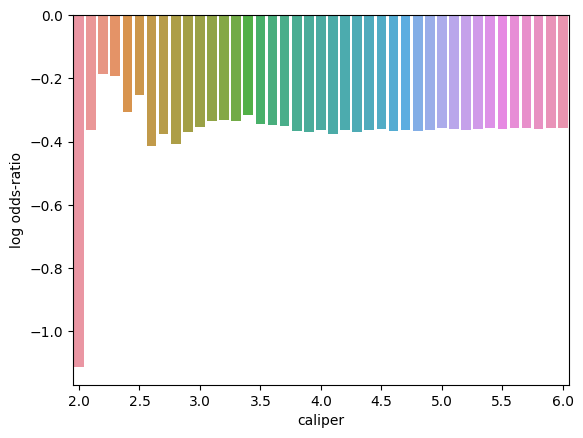

In [26]:
calipers = np.linspace(2, 6, 41)
LORs = [apply_caliper(c) for c in calipers]

sns.barplot(data=pd.DataFrame({
    'caliper': calipers,
    'log odds-ratio': LORs
}), x='caliper', y='log odds-ratio')
plt.xticks(ticks=np.arange(0, 41, 5))

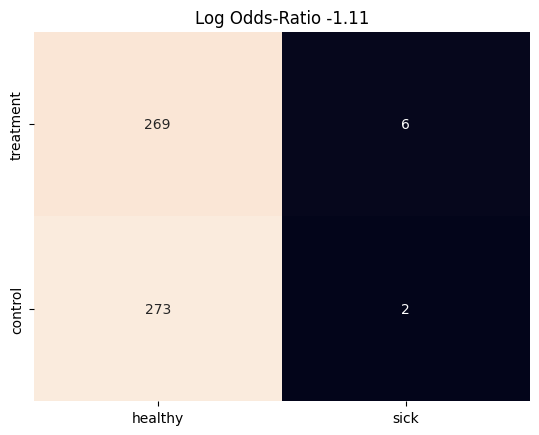

-1.1133727042512302

In [33]:
apply_caliper(c=2, print_counts=True)